In [3]:
!pip show opencv-python

In [4]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [5]:
!pip install opencv-contrib-python

   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/45.5 MB 1.0 MB/s eta 0:00:43
    --------------------------------------- 0.8/45.5 MB 1.2 MB/s eta 0:00:38
    --------------------------------------- 0.8/45.5 MB 1.2 MB/s eta 0:00:38
   - -------------------------------------- 1.3/45.5 MB 1.3 MB/s eta 0:00:35
   - -------------------------------------- 1.8/45.5 MB 1.4 MB/s eta 0:00:31
   - -------------------------------------- 2.1/45.5 MB 1.4 MB/s eta 0:00:31
   -- ------------------------------------- 2.4/45.5 MB 1.4 MB/s eta 0:00:30
   -- ------------------------------------- 2.6/45.5 MB 1.4 MB/s eta 0:00:31
   -- ------------------------------------- 2.9/45.5 MB 1.4 MB/s eta 0:00:32
   -- ------------------------------------- 3.1/45.5 MB 1.4 MB/s eta 0:00:31
   -- --------------

In [8]:
import os

In [9]:
from glob import glob

In [10]:
import cv2

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import tensorflow as tf

In [14]:
from tensorflow.keras.applications import ResNet50

In [15]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [16]:
from tensorflow.keras.models import Model

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
ct_path = r"D:\SRM\Github codes\Datasets\heart tumor detection\Dataset\Brain Tumor CT scan Images"
mri_path = r"D:\SRM\Github codes\Datasets\heart tumor detection\Dataset\Brain Tumor MRI images"

In [20]:
data = []

# CT_Scan
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(ct_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder 
        data.append((file, label, 'CT'))  # add (img path , label and source)

# MRI
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(mri_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder
        data.append((file, label, 'MRI')) # add (img path , label and source)

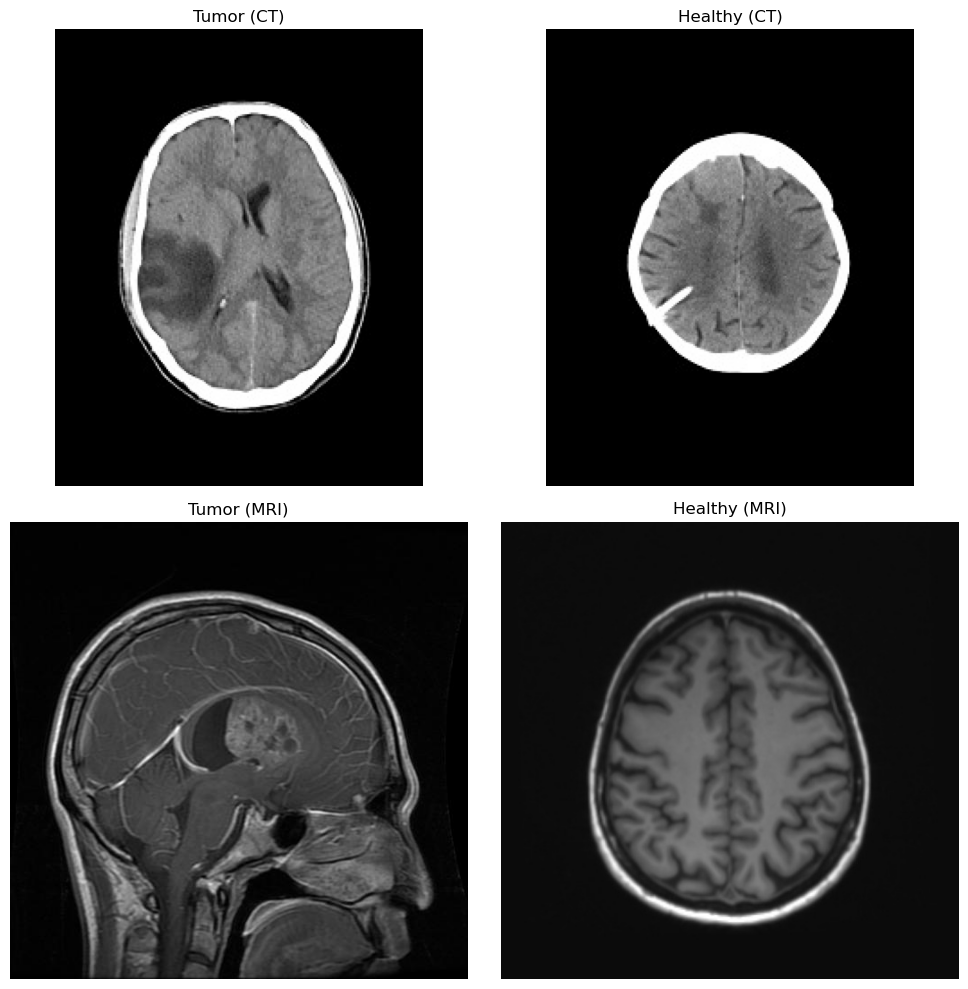

In [21]:
# some images
ct_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'CT')  # Tumor from CT
ct_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'CT')  # Healthy from CT
mri_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'MRI')  # Tumor from MRI
mri_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'MRI')  # Healthy from MRI

# add iamges to list
selected_images = [ct_patient, ct_healthy, mri_patient, mri_healthy]

# show the images 
plt.figure(figsize=(10, 10))  

for i, (path, label, source) in enumerate(selected_images):
    img = cv2.imread(path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    
    plt.subplot(2, 2, i + 1)  
    plt.imshow(img)
    plt.title(f"{label} ({source})") 
    plt.axis('off') 

plt.tight_layout() 
plt.show()

In [22]:
# conert data to array
image_paths = [item[0] for item in data]
labels = [item[1] for item in data]
sources = [item[2] for item in data]

# convert labels to numbers 
label_map = {'Tumor': 1, 'Healthy': 0}
labels = np.array([label_map[label] for label in labels])

In [23]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [24]:
# (Data Generator) with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest',  
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [25]:
def generate_images(image_paths, labels, batch_size=32, target_size=(224, 224)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            images = []
            for img_path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)

            images = np.array(images)
            yield images, np.array(batch_labels)

train_generator = generate_images(train_paths, train_labels, batch_size=32)
val_generator = generate_images(val_paths, val_labels, batch_size=32)

In [26]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#  Fine-Tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # one output (tumor / healthy)

# bulid the model
model = Model(inputs=base_model.input, outputs=predictions)

# while training , trainable = false 
for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model 
model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    validation_data=val_generator,
    validation_steps=len(val_paths) // 32,
    epochs=10
)

94765736/94765736 [==============================] - 52s 1us/step
Epoch 1/10
240/240 [==============================] - 628s 3s/step - loss: 0.2215 - accuracy: 0.9150 - val_loss: 0.1145 - val_accuracy: 0.9589
Epoch 2/10
240/240 [==============================] - 609s 3s/step - loss: 0.0964 - accuracy: 0.9632 - val_loss: 0.0932 - val_accuracy: 0.9677
Epoch 3/10
240/240 [==============================] - 614s 3s/step - loss: 0.0688 - accuracy: 0.9761 - val_loss: 0.0861 - val_accuracy: 0.9740
Epoch 4/10
240/240 [==============================] - 531s 2s/step - loss: 0.0528 - accuracy: 0.9828 - val_loss: 0.0863 - val_accuracy: 0.9750
Epoch 5/10
240/240 [==============================] - 284s 1s/step - loss: 0.0398 - accuracy: 0.9872 - val_loss: 0.0858 - val_accuracy: 0.9740
Epoch 6/10
240/240 [==============================] - 304s 1s/step - loss: 0.0336 - accuracy: 0.9894 - val_loss: 0.0882 - val_accuracy: 0.9724
Epoch 7/10
240/240 [==============================] - 293s 1s/step - loss: 0

In [28]:
# to evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_paths) // 32)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

60/60 [==============================] - 59s 982ms/step - loss: 0.2171 - accuracy: 0.9333
Validation Loss: 0.2171166092157364
Validation Accuracy: 0.9333333373069763
